In [1]:
import numpy as np
from ase import Atoms
from ase.calculators.vasp import Vasp  # Example calculator, replace with the actual calculator you use
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from ase.io import read
from phonopy.units import VaspToTHz
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from ase.dft.kpoints import  get_special_points
import os
import matplotlib.pyplot as plt
from ase.io.lammpsdata import write_lammps_data

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('shera')

In [4]:
atoms = read('/work/scratch/as41vomu/PhD/pyiron_projects/bto_paper_tests/004_ev_curve/DFT_elastic_constants/relax/mp-2998/CONTCAR')
atoms

Atoms(symbols='BaTiO3', pbc=True, cell=[[4.036179374905413, 0.0, 2e-16], [-2e-16, 4.036179374905413, 2e-16], [0.0, -0.0, 4.036179374905413]])

In [5]:
class PhononCalculation:
    def __init__(self, atoms: Atoms, supercell_matrix: list, displacement_distance: float, calc_type= 'vasp'):
        self.atoms = atoms
        self.supercell_matrix = supercell_matrix
        self.displacement_distance = displacement_distance
        self.phonon = None
        self.supercells = None
        self.fc = False
        self.mesh = False
        self.calc_type = calc_type

    def ase_to_phonopy(self):
        phonopy_atoms = PhonopyAtoms(symbols=self.atoms.get_chemical_symbols(),
                                     scaled_positions=self.atoms.get_scaled_positions(),
                                     cell=self.atoms.get_cell())
        return phonopy_atoms

    def phonopy_to_ase(self, phonopy_atoms):
        ase_atoms = Atoms(symbols=phonopy_atoms.get_chemical_symbols(),
                          positions=phonopy_atoms.get_positions(),
                          cell=phonopy_atoms.get_cell(),
                          pbc=True)
        return ase_atoms
    
    def setup_phonon(self, calculator=None):
        if self.calc_type == 'vasp':
            self.setup_phonon_vasp(calculator)
        elif self.calc_type == 'lammps':
            self.setup_phonon_lammps()
        else:
            raise ValueError('Unsupported calculator type. Supported types: "vasp", "lammps".')

    def setup_phonon_vasp(self, calculator):
        phonopy_atoms = self.ase_to_phonopy()
        self.phonon = Phonopy(phonopy_atoms, supercell_matrix=self.supercell_matrix, factor=VaspToTHz)
        self.phonon.generate_displacements(distance=self.displacement_distance)
        self.supercells = self.phonon.supercells_with_displacements

        for i, su in enumerate(self.supercells):
            ase_atoms = self.phonopy_to_ase(su)
            if calculator is None:
                raise ValueError('Calculator not provided')
            ase_atoms.set_calculator(calculator)
            directory = f'./displacement-{i}'
            os.makedirs(directory, exist_ok=True)
            calculator.set(directory=directory)
            calculator.write_input(ase_atoms)
        
        self.phonon.save("phonopy_disp.yaml")

    def setup_phonon_lammps(self):
        phonopy_atoms = self.ase_to_phonopy()
        self.phonon = Phonopy(phonopy_atoms, supercell_matrix=self.supercell_matrix, factor=VaspToTHz)
        self.phonon.generate_displacements(distance=self.displacement_distance)
        self.supercells = self.phonon.supercells_with_displacements
        self.phonon.save("phonopy_disp.yaml")

        for i, su in enumerate(self.supercells):
            ase_atoms = self.phonopy_to_ase(su)
            directory = f'./displacement-{i}'
            os.makedirs(directory, exist_ok=True)
            write_lammps_data(f'{directory}/data.lammps', ase_atoms, specorder=None, atom_style='atomic', masses=True)

                
    def calculate_fc(self):
        if self.calc_type == 'vasp':
            self.calculate_fc_vasp()
        elif self.calc_type == 'lammps':
            self.calculate_fc_lammps()
        else:
            raise ValueError('Unsupported calculator type. Supported types: "vasp", "lammps".')

    def calculate_fc_vasp(self):
        sets_of_forces = []
        for i, su in enumerate(self.supercells):
            directory = f'./displacement-{i}'
            if os.path.exists(f'{directory}/OUTCAR'):
                atoms = read(f'{directory}/OUTCAR', format='vasp-out')
                forces = atoms.get_forces()
                sets_of_forces.append(forces)
            else:
                raise FileNotFoundError(f'OUTCAR file does not exist in {directory}')

        self.phonon.forces = sets_of_forces
        self.phonon.produce_force_constants()
        self.phonon.save(settings={'force_constants': True})
        self.force_constants_calculated = True
            
    def calculate_fc_lammps(self):
        sets_of_forces = []
        for i, su in enumerate(self.supercells):
            directory = f'./displacement-{i}'
            if os.path.exists(f'{directory}/lmp.dump'):
                atoms = read(f'{directory}/lmp.dump', format='lammps-dump-text', index=-1)
                forces = atoms.get_forces()
                sets_of_forces.append(forces)
            else:
                raise FileNotFoundError(f'lmp.dump file does not exist in {directory}')

        self.phonon.forces = sets_of_forces
        self.phonon.produce_force_constants()
        self.phonon.save(settings={'force_constants': True})
        self.force_constants_calculated = True

        
    def _run_mesh(self, mesh=[20,20,20]):
        self.phonon.run_mesh( with_eigenvectors=True, is_mesh_symmetry=False)
        mesh_dict = self.phonon.get_mesh_dict()
        qpoints = mesh_dict['qpoints']
        weights = mesh_dict['weights']
        frequencies = mesh_dict['frequencies']
        eigenvectors = mesh_dict['eigenvectors']
        # best way to save it in single file
        # check if a folder exists with name mesh_data if not create one
        if not os.path.exists('mesh_data'):
            os.makedirs('mesh_data')
        np.save('mesh_data/qpoints.npy', qpoints)
        np.save('mesh_data/weights.npy', weights)
        np.save('mesh_data/frequencies.npy', frequencies)
        np.save('mesh_data/eigenvectors.npy', eigenvectors)
        self.mesh = True
        
    def phonon_dos(self):
        if not self.fc:
            self.calculte_fc()
        if not self.mesh:
            self._run_mesh()
        self.phonon.run_total_dos()
        self.phonon.run_projected_dos()
        total_dos_dict = self.phonon.get_total_dos_dict()
        projected_dos_dict = self.phonon.get_projected_dos_dict()
        frequencies_tot, total_dos = total_dos_dict['frequencies'], total_dos_dict['total_dos']
        frequencies_proj, projected_dos = projected_dos_dict['frequencies'], projected_dos_dict['projected_dos']

        if not os.path.exists('dos_data'):
            os.makedirs('dos_data')
        np.save('dos_data/frequencies_tot.npy', frequencies_tot)
        np.save('dos_data/total_dos.npy', total_dos)
        np.save('dos_data/frequencies_proj.npy', frequencies_proj)
        np.save('dos_data/projected_dos.npy', projected_dos)
    
    def phonon_band_structure(self, path_string=None):
        if not self.fc:
            self.calculate_fc()
        if not self.mesh:
            self._run_mesh()
            
        special_points = get_special_points(cell=atoms.get_cell())

        split_path = path_string.split(',')
        labels = []
        
        path = []

        # Loop through each segment in the path string
        for p in split_path:  
            tmp_list = []
            for point in p:
                labels.append(point)
                if point in special_points:
                    tmp_list.append(special_points[point].tolist())
            path.append(tmp_list)
        qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
        self.phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)   
        self.phonon.write_yaml_band_structure(filename='band.yaml')     
        frequencies = self.phonon.get_band_structure_dict()['frequencies']
        qpoints = self.phonon.get_band_structure_dict()['qpoints']
        distances = self.phonon.get_band_structure_dict()['distances']
        eigenvectors = self.phonon.get_band_structure_dict()['eigenvectors']
        # make a phonon_data file and save everything there
        if not os.path.exists('phonon_data'):
            os.makedirs('phonon_data')
        np.save('phonon_data/frequencies.npy', frequencies)
        np.save('phonon_data/qpoints.npy', qpoints)
        np.save('phonon_data/distances.npy', distances)
        np.save('phonon_data/eigenvectors.npy', eigenvectors)
        np.save('phonon_data/labels.npy', labels)
        # self.phonon.auto_band_structure(plot=True).show()



In [103]:
atoms

Atoms(symbols='BaTiO3', pbc=True, cell=[[4.036179374905413, 0.0, 2e-16], [-2e-16, 4.036179374905413, 2e-16], [0.0, -0.0, 4.036179374905413]])

In [104]:
calc = Vasp(encut=800,
            ediff=1e-7,
            ibrion=-1,
            lreal=False,
            gga='PE',
            kspacing=0.2,
            ismear=-5)

In [105]:
phc = PhononCalculation(atoms, supercell_matrix=[3,3,3], displacement_distance=0.1, calc_type='vasp')
phc.setup_phonon(calculator=calc)

In [106]:
phc.phonon_band_structure(path_string='GXMGRX,RM')

In [107]:
frequencies = np.load('phonon_data/frequencies.npy', allow_pickle=True)
qpoints = np.load('phonon_data/qpoints.npy', allow_pickle=True)
distances = np.load('phonon_data/distances.npy', allow_pickle=True)
eigenvectors = np.load('phonon_data/eigenvectors.npy', allow_pickle=True)
labels = np.load('phonon_data/labels.npy', allow_pickle=True)
# coordinates = np.load('phonon_data/coordinates.npy', allow_pickle=True)

In [125]:
# # Load phonon data
# frequencies = np.load('phonon_data/frequencies.npy', allow_pickle=True)
# qpoints = np.load('phonon_data/qpoints.npy', allow_pickle=True)
# distances = np.load('phonon_data/distances.npy', allow_pickle=True)
# eigenvectors = np.load('phonon_data/eigenvectors.npy', allow_pickle=True)
# labels = np.load('phonon_data/labels.npy', allow_pickle=True)
# # coordinates = np.load('phonon_data/coordinates.npy', allow_pickle=True)

# # Flatten the distance data for plotting
# x_data = distances.flatten()

# # Reshape frequency data for plotting
# y_data = frequencies.reshape(frequencies.shape[0] * frequencies.shape[1], -1)

# # Prepare special points indices and labels
# special_point_indices = [0]
# for d in distances:
#     special_point_indices.append(d[-1])
# # print(special_point_indices)

# # Plot phonon band structure
# plt.figure(figsize=(8, 6))
# for i in range(y_data.shape[1]):
#     plt.plot(x_data, y_data[:, i], 'r-')  # Plot each phonon band

# # Set x-ticks and labels for special points
# plt.xticks(special_point_indices, labels)
# plt.xlim(x_data[0], x_data[-1])

# # Plot formatting
# plt.axhline(y=0, color='b', linestyle='--')  # Add horizontal line at y=0
# plt.xlabel('Wave Vector')
# plt.ylabel('Frequency (THz)')



# plt.show()

In [91]:
distances.shape

(6, 51)

In [96]:
distances

array([[0.        , 0.00247759, 0.00495518, 0.00743277, 0.00991036,
        0.01238795, 0.01486554, 0.01734313, 0.01982072, 0.02229832,
        0.02477591, 0.0272535 , 0.02973109, 0.03220868, 0.03468627,
        0.03716386, 0.03964145, 0.04211904, 0.04459663, 0.04707422,
        0.04955181, 0.0520294 , 0.05450699, 0.05698458, 0.05946217,
        0.06193976, 0.06441736, 0.06689495, 0.06937254, 0.07185013,
        0.07432772, 0.07680531, 0.0792829 , 0.08176049, 0.08423808,
        0.08671567, 0.08919326, 0.09167085, 0.09414844, 0.09662603,
        0.09910362, 0.10158121, 0.1040588 , 0.10653639, 0.10901399,
        0.11149158, 0.11396917, 0.11644676, 0.11892435, 0.12140194,
        0.12387953],
       [0.12387953, 0.12635712, 0.12883471, 0.1313123 , 0.13378989,
        0.13626748, 0.13874507, 0.14122266, 0.14370025, 0.14617784,
        0.14865543, 0.15113303, 0.15361062, 0.15608821, 0.1585658 ,
        0.16104339, 0.16352098, 0.16599857, 0.16847616, 0.17095375,
        0.17343134, 0.17590

In [94]:
labels.shape

(8,)

/tmp/ipykernel_2970269/2658765174.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


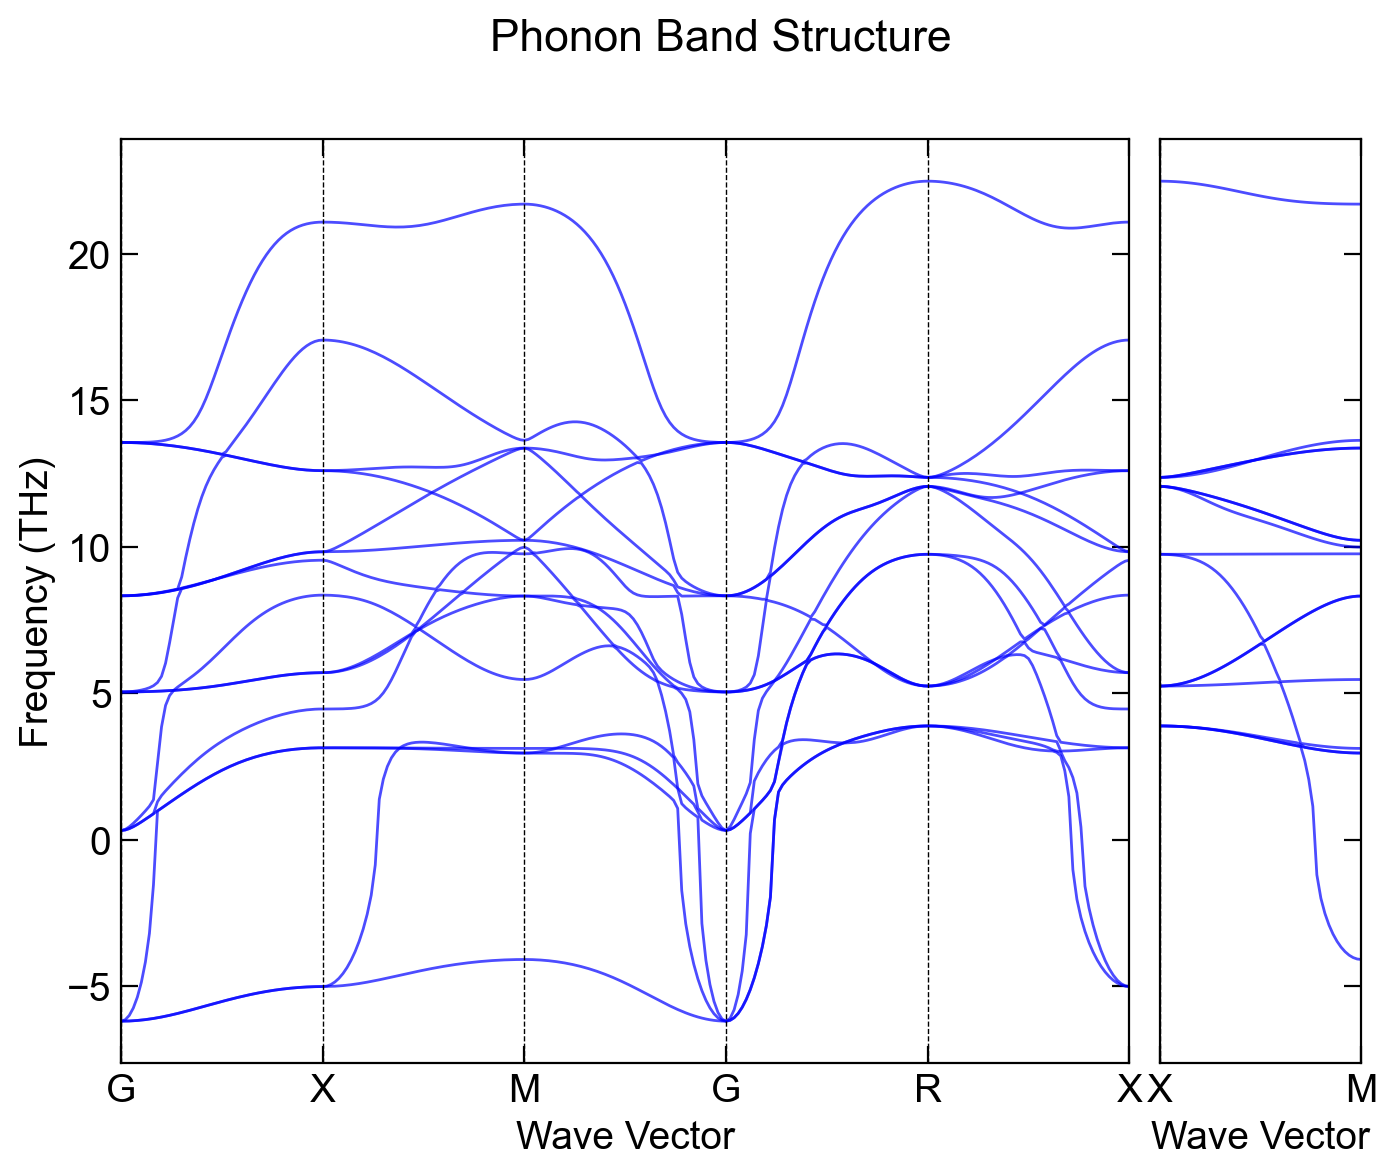

In [119]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def read_phonopy_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def extract_band_data(phonon_data):
    all_frequencies = []
    for point in phonon_data['phonon']:
        frequencies = [band['frequency'] for band in point['band']]
        all_frequencies.append(frequencies)
    return np.array(all_frequencies)

def plot_band_structure(frequencies, labels, segment_sizes):
    # Calculate the width ratio based on the number of segments in each subplot
    width_ratio = [sum(segment_sizes[:5]), sum(segment_sizes[5:])]
    
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratio, wspace=0.05)
    
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharey=ax1)
    
    total_points = sum(segment_sizes)
    points_per_segment = 51  # As per your YAML file
    
    # Calculate x-coordinates for each segment
    x_coords = np.concatenate([np.linspace(i, i+1, points_per_segment) for i in range(len(segment_sizes))])
    
    # Split data for two subplots
    split_index = sum(segment_sizes[:5])  # GXMGRX
    x_coords1, x_coords2 = np.split(x_coords, [split_index])
    freq1, freq2 = np.split(frequencies, [split_index])
    
    # Plot for first subplot (GXMGRX)
    for band in range(frequencies.shape[1]):
        ax1.plot(x_coords1, freq1[:, band], color='blue', linewidth=1, alpha=0.7)
    
    # Plot for second subplot (RM)
    for band in range(frequencies.shape[1]):
        ax2.plot(x_coords2 - x_coords2.min(), freq2[:, band], color='blue', linewidth=1, alpha=0.7)
    
    # Set labels and ticks for first subplot
    ax1.set_xticks(range(6))
    ax1.set_xticklabels(labels[:6])
    ax1.set_xlim(0, 5)
    
    # Set labels and ticks for second subplot
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(labels[5:])
    ax2.set_xlim(0, 1)
    
    # Remove y-axis ticks from the second subplot
    ax2.yaxis.set_tick_params(left=False, labelleft=False)
    
    # Set labels and title
    ax1.set_xlabel('Wave Vector')
    ax2.set_xlabel('Wave Vector')
    ax1.set_ylabel('Frequency (THz)')
    fig.suptitle('Phonon Band Structure', fontsize=16)
    
    # Add vertical lines at high symmetry points
    for ax, segments in zip([ax1, ax2], [5, 1]):
        for i in range(segments + 1):
            ax.axvline(x=i, color='k', linestyle='--', linewidth=0.5)
            
    
    plt.tight_layout()
    plt.savefig('phonon_band_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
file_path = 'band.yaml'  # Replace with your YAML file path
phonon_data = read_phonopy_yaml(file_path)
frequencies = extract_band_data(phonon_data)

labels = ['G', 'X', 'M', 'G', 'R', 'X', 'M']
segment_sizes = phonon_data['segment_nqpoint']

plot_band_structure(frequencies, labels, segment_sizes) 

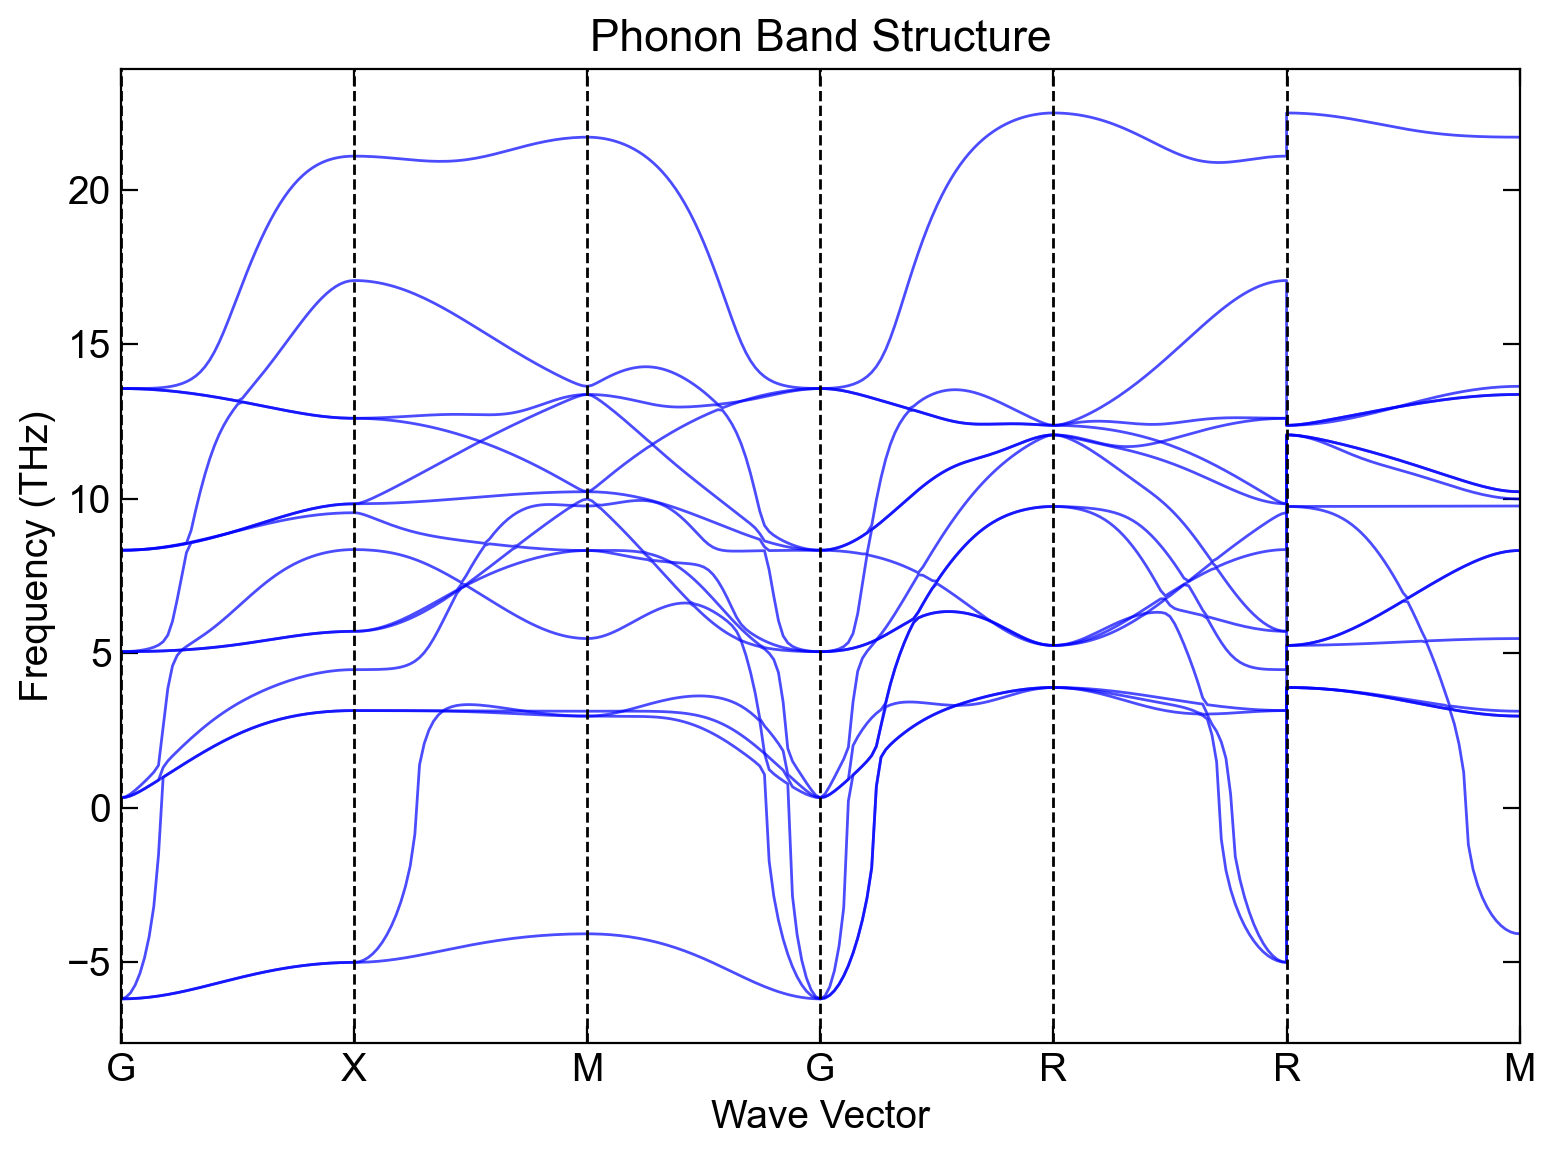

In [122]:
def read_phonopy_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def extract_band_data(phonon_data):
    all_frequencies = []
    for point in phonon_data['phonon']:
        frequencies = [band['frequency'] for band in point['band']]
        all_frequencies.append(frequencies)
    return np.array(all_frequencies)

def plot_band_structure(frequencies, labels, segment_sizes):
    total_segments = len(segment_sizes)
    cumulative_sizes = np.cumsum([0] + segment_sizes)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate x-coordinates for each segment
    x_coords = np.concatenate([np.linspace(start, end, size) 
                               for start, end, size in zip(range(total_segments), range(1, total_segments+1), segment_sizes)])
    
    # Plot all bands
    for band in range(frequencies.shape[1]):
        ax.plot(x_coords, frequencies[:, band], color='blue', linewidth=1, alpha=0.7)
    
    # Set labels and ticks
    tick_positions = range(total_segments + 1)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels)
    ax.set_xlim(0, total_segments)
    
    # Add vertical lines at high symmetry points
    for i in tick_positions:
        ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
    
    # Set labels and title
    ax.set_xlabel('Wave Vector')
    ax.set_ylabel('Frequency (THz)')
    ax.set_title('Phonon Band Structure', fontsize=16)
    
    plt.tight_layout()
    plt.savefig('phonon_band_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
file_path = 'band.yaml'  # Replace with your YAML file path
phonon_data = read_phonopy_yaml(file_path)
frequencies = extract_band_data(phonon_data)

# Extract labels, ensuring we don't duplicate intermediate labels
labels = [segment[0] for segment in phonon_data['labels']] + [phonon_data['labels'][-1][-1]]
segment_sizes = phonon_data['segment_nqpoint']

plot_band_structure(frequencies, labels, segment_sizes)

/tmp/ipykernel_2348191/4119484235.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


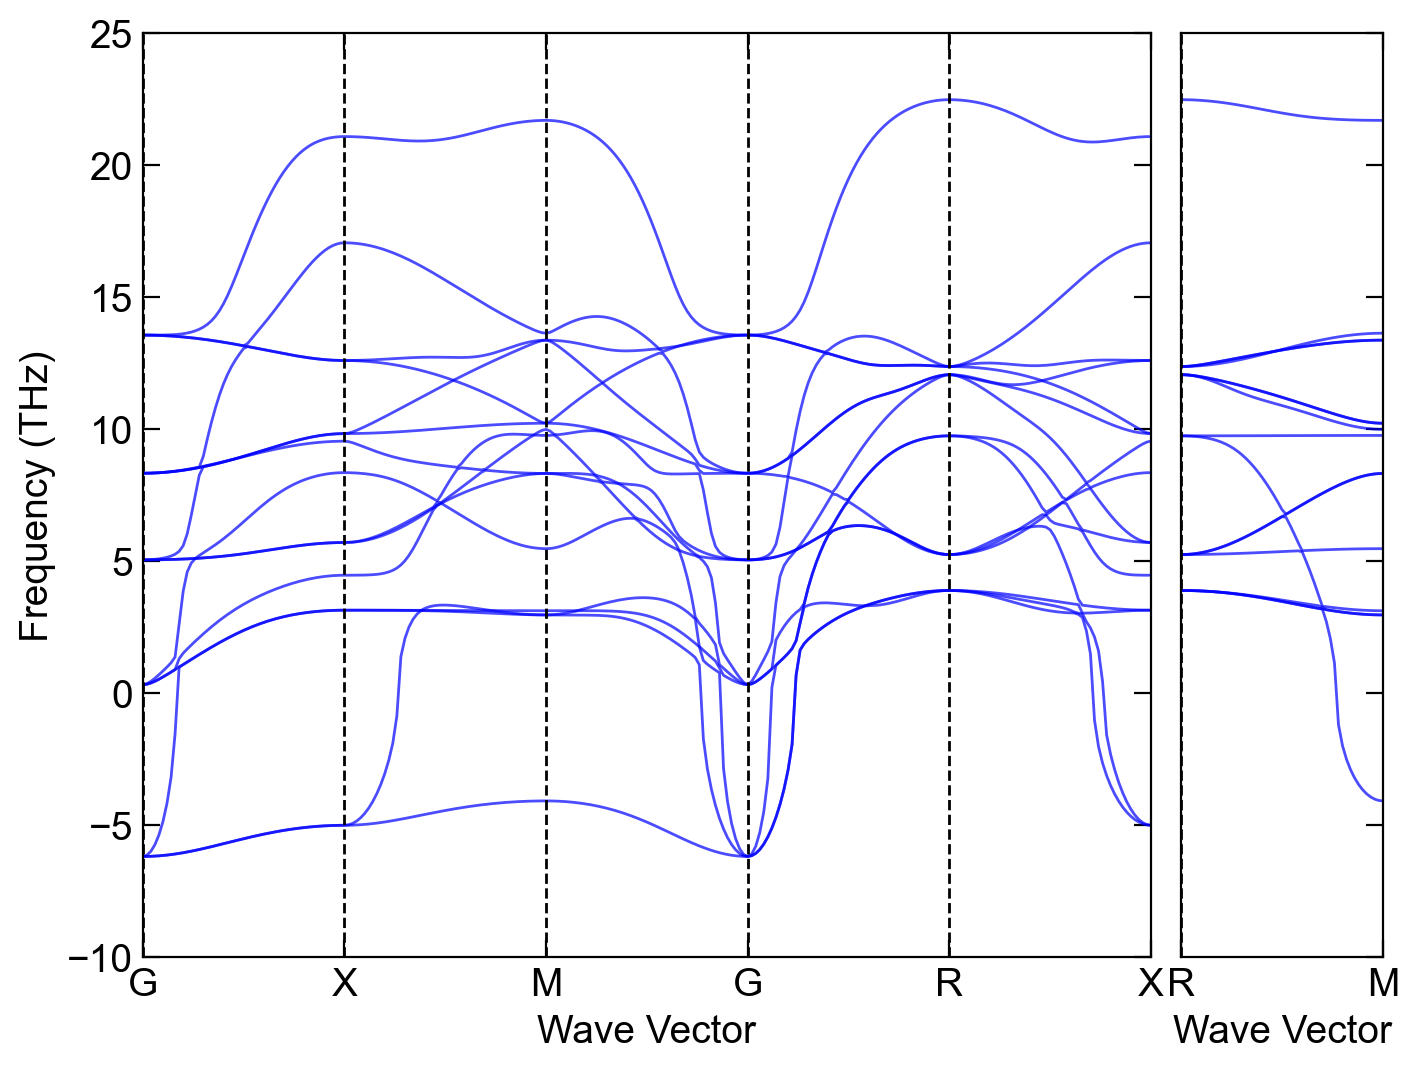

In [8]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def read_phonopy_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def extract_band_data(phonon_data):
    all_frequencies = []
    for point in phonon_data['phonon']:
        frequencies = [band['frequency'] for band in point['band']]
        all_frequencies.append(frequencies)
    return np.array(all_frequencies)

def plot_band_structure(frequencies, path_string, segment_sizes):
    # Split the path string into two parts if there's a comma
    paths = path_string.split(',')
    labels = [list(path) for path in paths]
    
    # Calculate the width ratio based on the number of segments in each subplot
    width_ratio = [sum(segment_sizes[:len(labels[0])-1])]
    if len(paths) > 1:
        width_ratio.append(sum(segment_sizes[len(labels[0])-1:]))
    
    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, len(paths), width_ratios=width_ratio, wspace=0.05)
    
    axes = [plt.subplot(gs[0])]
    if len(paths) > 1:
        axes.append(plt.subplot(gs[1], sharey=axes[0]))
    
    total_points = sum(segment_sizes)
    points_per_segment = segment_sizes[0]  # Assuming all segments have the same number of points
    
    # Calculate x-coordinates for each segment
    x_coords = np.concatenate([np.linspace(i, i+1, points_per_segment) for i in range(len(segment_sizes))])
    
    # Split data for subplots
    split_index = sum(segment_sizes[:len(labels[0])-1])
    x_coords_split = np.split(x_coords, [split_index]) if len(paths) > 1 else [x_coords]
    freq_split = np.split(frequencies, [split_index]) if len(paths) > 1 else [frequencies]
    
    for ax, x_coord, freq, lab in zip(axes, x_coords_split, freq_split, labels):
        # Plot bands
        for band in range(frequencies.shape[1]):
            ax.plot(x_coord - x_coord.min(), freq[:, band], color='blue', linewidth=1, alpha=0.7)
        
        # Set labels and ticks
        ax.set_xticks(range(len(lab)))
        ax.set_xticklabels(lab)
        ax.set_xlim(0, len(lab) - 1)
        ax.set_ylim(-10, 25)  # Adjust the y-limit as needed
        
        # Add vertical lines at high symmetry points
        for i in range(len(lab)):
            ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
        
        # Set labels
        ax.set_xlabel('Wave Vector')
    
    # Remove y-axis ticks from the second subplot if it exists
    if len(axes) > 1:
        axes[1].yaxis.set_tick_params(left=False, labelleft=False)
    
    # Set y-label only for the first subplot
    axes[0].set_ylabel('Frequency (THz)')
    
    
    plt.tight_layout()
    plt.savefig('phonon_band_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
file_path = 'band.yaml'  # Replace with your YAML file path
phonon_data = read_phonopy_yaml(file_path)
frequencies = extract_band_data(phonon_data)

path_string = 'GXMGRX,RM'  # This can be changed to any valid path
segment_sizes = phonon_data['segment_nqpoint']

plot_band_structure(frequencies, path_string, segment_sizes)

In [111]:
labels

['G', 'X', 'M', 'G', 'R', 'R']

In [95]:
labels

array(['G', 'X', 'M', 'G', 'R', 'X', 'R', 'M'], dtype='<U1')

In [101]:
distances[:-1]

array([[0.        , 0.00247759, 0.00495518, 0.00743277, 0.00991036,
        0.01238795, 0.01486554, 0.01734313, 0.01982072, 0.02229832,
        0.02477591, 0.0272535 , 0.02973109, 0.03220868, 0.03468627,
        0.03716386, 0.03964145, 0.04211904, 0.04459663, 0.04707422,
        0.04955181, 0.0520294 , 0.05450699, 0.05698458, 0.05946217,
        0.06193976, 0.06441736, 0.06689495, 0.06937254, 0.07185013,
        0.07432772, 0.07680531, 0.0792829 , 0.08176049, 0.08423808,
        0.08671567, 0.08919326, 0.09167085, 0.09414844, 0.09662603,
        0.09910362, 0.10158121, 0.1040588 , 0.10653639, 0.10901399,
        0.11149158, 0.11396917, 0.11644676, 0.11892435, 0.12140194,
        0.12387953],
       [0.12387953, 0.12635712, 0.12883471, 0.1313123 , 0.13378989,
        0.13626748, 0.13874507, 0.14122266, 0.14370025, 0.14617784,
        0.14865543, 0.15113303, 0.15361062, 0.15608821, 0.1585658 ,
        0.16104339, 0.16352098, 0.16599857, 0.16847616, 0.17095375,
        0.17343134, 0.17590

In [12]:
lmps_atoms = read('/work/scratch/as41vomu/PhD/pyiron_projects/GBs/006_GBs_cell_size_static/cubic_su_relax_hdf5/cubic_su_relax/relaxation.dump', format='lammps-dump-text', index=-1)

In [15]:
atoms

Atoms(symbols='BaTiO3', pbc=True, cell=[[4.036179374905413, 0.0, 2e-16], [-2e-16, 4.036179374905413, 2e-16], [0.0, -0.0, 4.036179374905413]])

In [16]:
import seekpath

In [97]:
seekpath.get_path(structure=(atoms.cell, atoms.get_scaled_positions(), atoms.get_atomic_numbers()), with_time_reversal=True)


{'point_coords': {'GAMMA': [0.0, 0.0, 0.0],
  'R': [0.5, 0.5, 0.5],
  'M': [0.5, 0.5, 0.0],
  'X': [0.0, 0.5, 0.0],
  'X_1': [0.5, 0.0, 0.0]},
 'path': [('GAMMA', 'X'),
  ('X', 'M'),
  ('M', 'GAMMA'),
  ('GAMMA', 'R'),
  ('R', 'X'),
  ('R', 'M')],
 'has_inversion_symmetry': True,
 'augmented_path': False,
 'bravais_lattice': 'cP',
 'bravais_lattice_extended': 'cP2',
 'conv_lattice': array([[4.03617937, 0.        , 0.        ],
        [0.        , 4.03617937, 0.        ],
        [0.        , 0.        , 4.03617937]]),
 'conv_positions': array([[0.5, 0.5, 0.5],
        [0. , 0. , 0. ],
        [0.5, 0. , 0. ],
        [0. , 0.5, 0. ],
        [0. , 0. , 0.5]]),
 'conv_types': array([56, 22,  8,  8,  8], dtype=int32),
 'primitive_lattice': array([[4.03617937, 0.        , 0.        ],
        [0.        , 4.03617937, 0.        ],
        [0.        , 0.        , 4.03617937]]),
 'primitive_positions': array([[0.5, 0.5, 0.5],
        [0. , 0. , 0. ],
        [0.5, 0. , 0. ],
        [0. , 

In [14]:
lmps_atoms.get_forces()

array([[ 5.27356e-15,  1.34566e-15,  3.13736e-15],
       [ 7.37188e-14, -9.99201e-16,  2.36200e-14],
       [-7.18869e-15,  1.01863e-14,  1.32164e-14],
       ...,
       [-4.27436e-14,  8.50420e-15, -4.88914e-14],
       [ 5.86198e-14,  7.18869e-15,  2.46925e-15],
       [-4.35763e-14, -5.02376e-15,  4.16453e-15]])

In [ ]:
import seekpath
